In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [3]:
torch.cuda.is_available()

False

In [44]:
device="cpu"

# Data Prepare

In [5]:
os.getcwd()

'/content'

In [6]:
root = os.path.join('/content/drive/MyDrive/Colab Notebooks/멋사쏘카2기/Assignment')

## 5.1.1. MNIST

In [7]:
mnist_train = datasets.MNIST(
    root=root,
    train=True,
    download=True,
    transform = transforms.ToTensor()
)

mnist_test = datasets.MNIST(
    root=root,
    train=False,
    download=True,
    transform=transforms.ToTensor()   
)

# ToTensor ==> 이미지를 tensor 데이터로 바꿔줌, 각 픽셀의 값(0~255)를 정규화(0~1)도 시켜줌

In [8]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/Colab Notebooks/멋사쏘카2기/Assignment
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
sample_x, sample_y = mnist_train[0]

print(sample_x.shape)
print(sample_y)

torch.Size([1, 28, 28])
5


In [10]:
mnist_train.targets.shape, mnist_train.targets.unique()
# 총 6000개 data, 10개의 클래스

(torch.Size([60000]), tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [11]:
def plot_mnist(data, figsize=(20,10)):
  fig = plt.figure(figsize=figsize)
  for i in range(18):
    img = data[i][0]
    ax = fig.add_subplot(3,6,i+1)
    ax.imshow(img.reshape(28,28), cmap='gray')
    ax.set_title(f"Label : {data[i][1]}")
  fig.show()
  pass

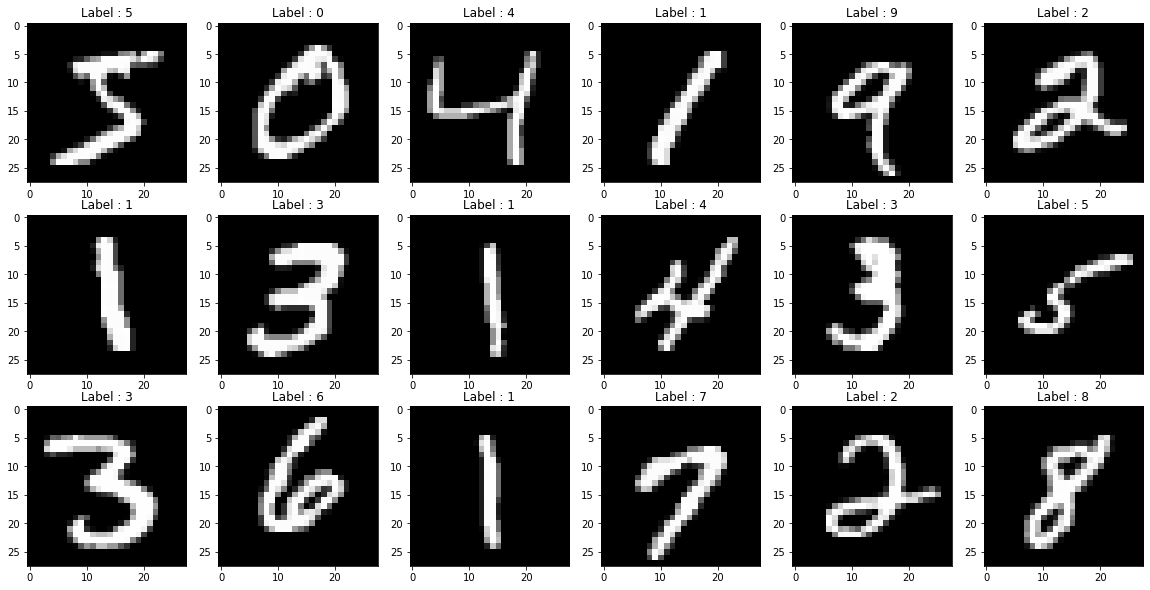

In [12]:
plot_mnist(data=mnist_train)

## 5.1.2. Fashion MNIST

In [13]:
fmnist_train = datasets.FashionMNIST(
    root=root, 
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
)
fmnist_test = datasets.FashionMNIST(
    root=root, 
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
)

In [14]:
fmnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/Colab Notebooks/멋사쏘카2기/Assignment
    Split: Train
    StandardTransform
Transform: ToTensor()

In [15]:
fmnist_train.targets.shape, fmnist_train.targets.unique()

(torch.Size([60000]), tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

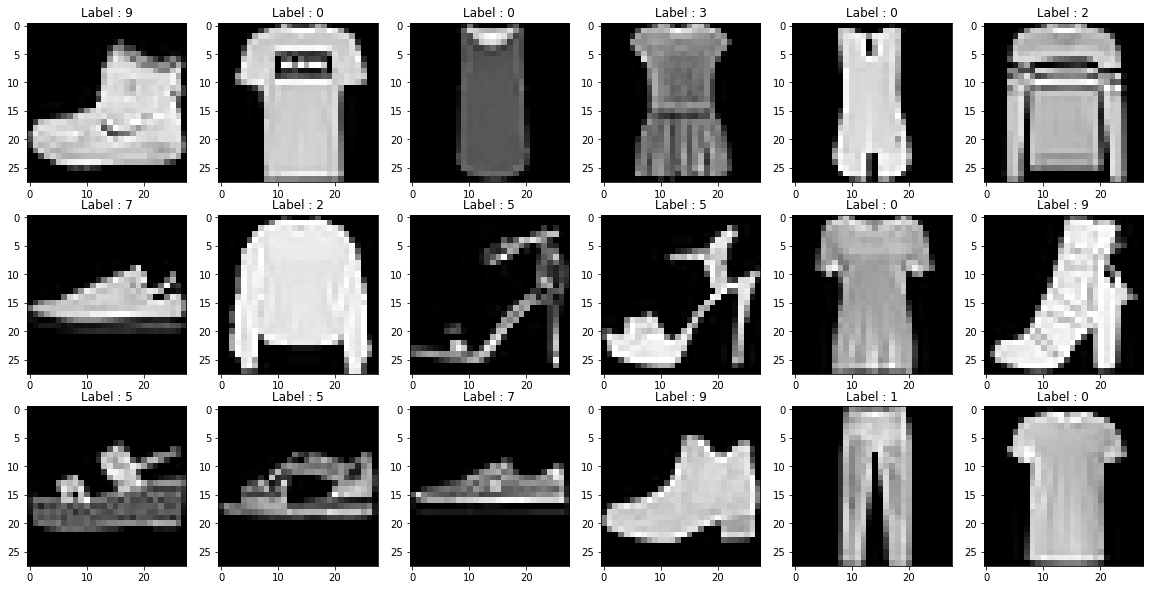

In [16]:
plot_mnist(data=fmnist_train)

## 5.1.3. KMNIST
- 일본어 데이터

In [17]:
kmnist_train = datasets.KMNIST(
    root=root, 
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
)
kmnist_test = datasets.KMNIST(
    root=root, 
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
)

In [18]:
kmnist_train

Dataset KMNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/Colab Notebooks/멋사쏘카2기/Assignment
    Split: Train
    StandardTransform
Transform: ToTensor()

In [19]:
kmnist_train.targets.shape, kmnist_train.targets.unique()

(torch.Size([60000]), tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

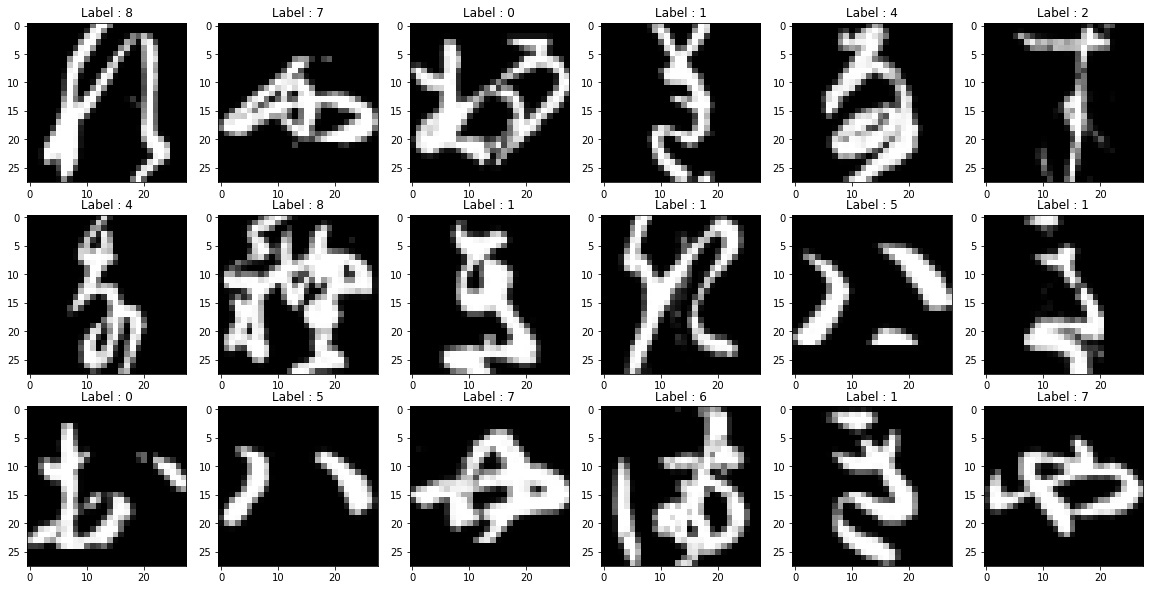

In [20]:
plot_mnist(data=kmnist_train)

## 5.1.4. EMNIST
- unbalance 되어있는 데이터
- 아마 여기서 하긴 좀 어려울듯??

In [21]:
emnist_train = datasets.EMNIST(
    root=root,
    split="byclass",  
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
)
emnist_test = datasets.EMNIST(
    root=root,
    split="byclass",
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
)

In [22]:
emnist_train

Dataset EMNIST
    Number of datapoints: 697932
    Root location: /content/drive/MyDrive/Colab Notebooks/멋사쏘카2기/Assignment
    Split: Train
    StandardTransform
Transform: ToTensor()

In [23]:
emnist_train.targets.shape, emnist_train.targets.unique()
# 총 62개의 클래스

(torch.Size([697932]),
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61]))

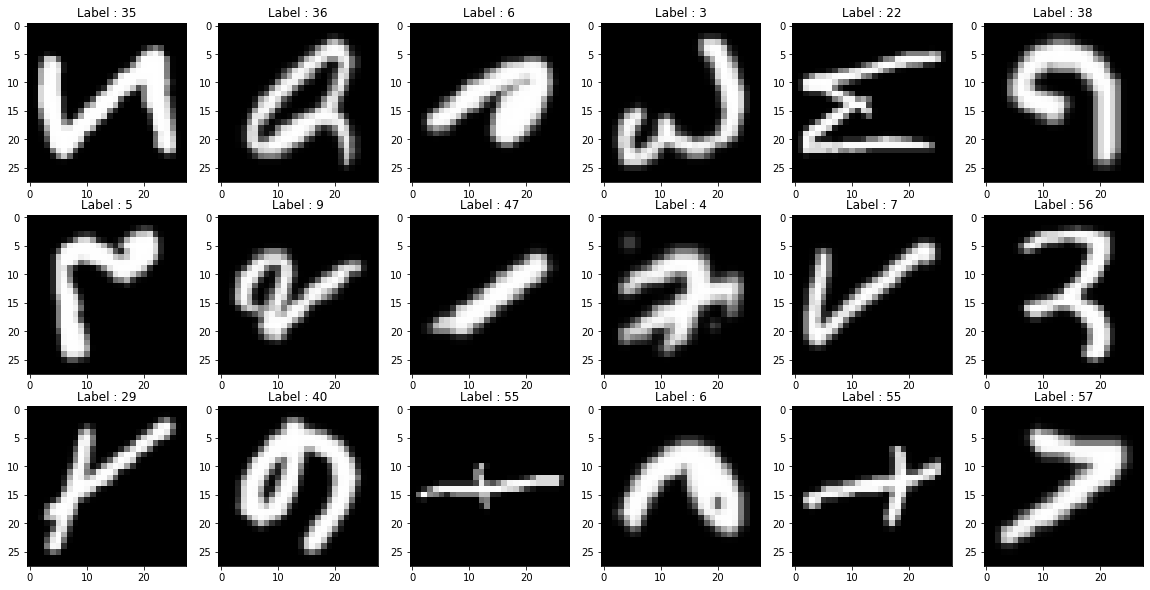

In [24]:
plot_mnist(data=emnist_train)

## 5.1.5. Train Test Split

In [25]:
# Performance Monitoring을 위해 train, test split

class mnist_dataset(Dataset):
  def __init__(self, data, targets, transform=None, target_transform=None):
    super().__init__()

    self.data = data
    self.targets = targets
    self.transform = transform
    self.target_transform = target_transform
    pass

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    x, y = self.data[idx], self.targets[idx]

    if self.transform:
      x = self.transform(x)
    if self.target_transform:
      y = self.target_transform(y)

    return x, y

In [26]:
# Dateset이 주어졌을 때, Train&Test로 나누기

def split_train_valid(dataset, valid_ratio=0.1):
  n_valid = int(len(dataset)*valid_ratio)   #90%는 train, 10%는 valid

  train_data = dataset.data[:-n_valid].numpy()
  valid_data = dataset.data[-n_valid:].numpy()

  train_targets = dataset.targets[:-n_valid]
  valid_targets = dataset.targets[-n_valid:]

  train = mnist_dataset(data=train_data, targets=train_targets, transform=dataset.transform, target_transform=dataset.target_transform)
  valid = mnist_dataset(data=valid_data, targets=valid_targets, transform=dataset.transform, target_transform=dataset.target_transform)

  return train, valid


In [27]:
# 각 mnist에 대한 train, valid 
mnist_train, mnist_valid = split_train_valid(dataset=mnist_train)
fmnist_train, fmnist_valid = split_train_valid(dataset=fmnist_train)
kmnist_train, kmnist_valid = split_train_valid(dataset=kmnist_train)
emnist_train, emnist_valid = split_train_valid(dataset=emnist_train)

In [28]:
# 각 mnist의 정보 저장

mnists = {}
mnists["mnist"] = {"train": mnist_train, "valid": mnist_valid, "test": mnist_test}
mnists["fmnist"] = {"train": fmnist_train, "valid": fmnist_valid, "test": fmnist_test}
mnists["kmnist"] = {"train": kmnist_train, "valid": kmnist_valid, "test": kmnist_test}
mnists["emnist"] = {"train": emnist_train, "valid": emnist_valid, "test": emnist_test}

for k in mnists.keys():
  print(f"Length of {k}: train - {len(mnists[k]['train'])}, valid - {len(mnists[k]['valid'])}, test - {len(mnists[k]['test'])}.")

Length of mnist: train - 54000, valid - 6000, test - 10000.
Length of fmnist: train - 54000, valid - 6000, test - 10000.
Length of kmnist: train - 54000, valid - 6000, test - 10000.
Length of emnist: train - 628139, valid - 69793, test - 116323.


In [29]:
loaders = {}
for k in mnists.keys():
  loaders[k] = {s: DataLoader(dataset=mnists[k][s], batch_size=512 if k == "emnist" else 64, shuffle= s == "train", drop_last=True) for s in ["train", "valid", "test"]}

In [30]:
loaders

{'emnist': {'test': <torch.utils.data.dataloader.DataLoader at 0x7f2e1ef6a790>,
  'train': <torch.utils.data.dataloader.DataLoader at 0x7f2e1e3e4150>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x7f2e1e3e49d0>},
 'fmnist': {'test': <torch.utils.data.dataloader.DataLoader at 0x7f2e1e3e44d0>,
  'train': <torch.utils.data.dataloader.DataLoader at 0x7f2e1e3e4c90>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x7f2e1e3e4d90>},
 'kmnist': {'test': <torch.utils.data.dataloader.DataLoader at 0x7f2e1e3e4210>,
  'train': <torch.utils.data.dataloader.DataLoader at 0x7f2e1e3e4e90>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x7f2e1e3e4350>},
 'mnist': {'test': <torch.utils.data.dataloader.DataLoader at 0x7f2e1e735450>,
  'train': <torch.utils.data.dataloader.DataLoader at 0x7f2e1e735f50>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x7f2e1e7354d0>}}

# 5.2. Model Build

In [31]:
class myMNISTClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, n_class)
    )

  def forward(self,x):
    return self.model(x)

In [32]:
mlp = myMNISTClassifier()
mlp

myMNISTClassifier(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)

# 5.3. Trainer

In [51]:
class Trainer(nn.Module):
  def __init__(self, model_class, loaders, n_class=10, opt="sgd", lr=0.001, has_scheduler=False, device="cpu"):
    super().__init__()

    self.model = model_class(n_class=n_class)
    self.loss = nn.CrossEntropyLoss()
    
    self.train_loader = loaders["train"]
    self.valid_loader = loaders["valid"]
    self.test_loader = loaders["test"]

    self._get_optimizer(opt=opt.lower(), lr=lr)
    self.has_scheduler = has_scheduler
    if self.has_scheduler:
      self._get_scheduler()

    self.device = device
    pass


  def _get_optimizer(self, opt, lr=0.001):
    if opt == "sgd":
      self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
    elif opt == "adam":
      self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
    else:
      raise ValueError(f"optimizer {opt} is not supproted")


  def _get_scheduler(self):
    self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)


  def train(self, max_epochs=10):
    print("===== Train Start =====")
    history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}
    for e in range(max_epochs):
      train_loss, train_acc = self._train_epoch()
      valid_loss, valid_acc = self._valid_epoch()

      history["train_loss"].append(train_loss)
      history["train_acc"].append(train_acc)
      history["valid_loss"].append(valid_loss)
      history["valid_acc"].append(valid_acc)

      if self.has_scheduler:
        self.scheduler.step()

      if e % 5 == 0:
        print(f"Epoch: {e}, train loss: {train_loss:>6f}, train acc: {train_acc:>3f}, valid loss: {valid_loss:>6f}, valid acc: {valid_acc:>3f}")

    self.plot_history(history)

  def _train_epoch(self):
    epoch_loss, epoch_acc = 0, 0
    self.model.train()
    for (x, y) in self.train_loader:
      x = x.to(self.device)
      y = y.to(self.device)

      y_hat = self.model(x)
      loss = self.loss(y_hat, y)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      epoch_loss += loss.to("cpu").item()
      epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(self.train_loader)
    epoch_acc /= len(self.train_loader)

    return epoch_loss, epoch_acc
  

  def _valid_epoch(self):
    epoch_loss, epoch_acc = 0, 0
    self.model.eval()
    with torch.no_grad():
      for (x, y) in self.valid_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(self.valid_loader)
    epoch_acc /= len(self.valid_loader)

    return epoch_loss, epoch_acc


  def plot_history(self, history):
    fig = plt.figure(figsize=(20, 10))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history["train_loss"], color="red", label="train loss")
    ax.plot(history["valid_loss"], color="blue", label="valid loss")
    ax.set_title("Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history["train_acc"], color="red", label="train acc")
    ax.plot(history["valid_acc"], color="blue", label="valid acc")
    ax.set_title("Acc")
    ax.legend()

    fig.show()


  def test(self):
    print("===== Test Start =====")
    epoch_loss, epoch_acc = 0, 0
    self.model.eval()
    with torch.no_grad():
      for (x, y) in self.test_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(self.test_loader)
    epoch_acc /= len(self.test_loader)

    print(f"Test loss: {epoch_loss:>6f}, Test acc: {epoch_acc:>3f}")

===== Train Start =====
Epoch: 0, train loss: 2.286444, train acc: 0.137641, valid loss: 2.268893, valid acc: 0.201445
Epoch: 5, train loss: 1.748971, train acc: 0.690095, valid loss: 1.597748, valid acc: 0.735551
Epoch: 10, train loss: 0.791279, train acc: 0.808330, valid loss: 0.680458, valid acc: 0.854839
Epoch: 15, train loss: 0.541518, train acc: 0.857410, valid loss: 0.454248, valid acc: 0.889953
Epoch: 20, train loss: 0.449109, train acc: 0.877094, valid loss: 0.370932, valid acc: 0.905578
Epoch: 25, train loss: 0.402166, train acc: 0.888290, valid loss: 0.330385, valid acc: 0.910954
Epoch: 30, train loss: 0.373505, train acc: 0.895259, valid loss: 0.305396, valid acc: 0.915659
Epoch: 35, train loss: 0.352713, train acc: 0.900356, valid loss: 0.287859, valid acc: 0.920027
Epoch: 40, train loss: 0.336289, train acc: 0.904007, valid loss: 0.274863, valid acc: 0.923387
Epoch: 45, train loss: 0.323102, train acc: 0.907436, valid loss: 0.263905, valid acc: 0.926915
===== Test Start =

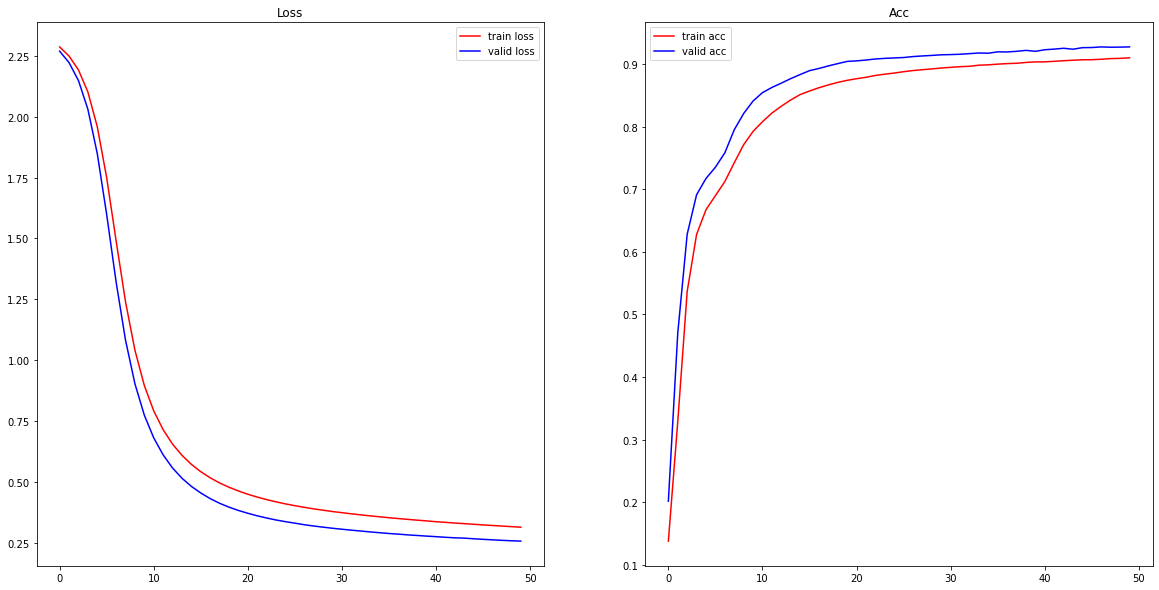

In [52]:
# mnist, scheduler X, sgd 
trainer = Trainer(model_class=myMNISTClassifier, loaders=loaders["mnist"], n_class=10, opt="sgd", lr=0.001, device=device).to(device)
trainer.train(max_epochs=50)
trainer.test()

===== Train Start =====
Epoch: 0, train loss: 0.302133, train acc: 0.915147, valid loss: 0.115650, valid acc: 0.966566
Epoch: 5, train loss: 0.031211, train acc: 0.989973, valid loss: 0.075061, valid acc: 0.979335
Epoch: 10, train loss: 0.011453, train acc: 0.996293, valid loss: 0.108871, valid acc: 0.976478
Epoch: 15, train loss: 0.011513, train acc: 0.995922, valid loss: 0.114807, valid acc: 0.978327
Epoch: 20, train loss: 0.006232, train acc: 0.998072, valid loss: 0.128495, valid acc: 0.982191
Epoch: 25, train loss: 0.005827, train acc: 0.998091, valid loss: 0.119247, valid acc: 0.980847
===== Test Start =====
Test loss: 0.131199, Test acc: 0.980569


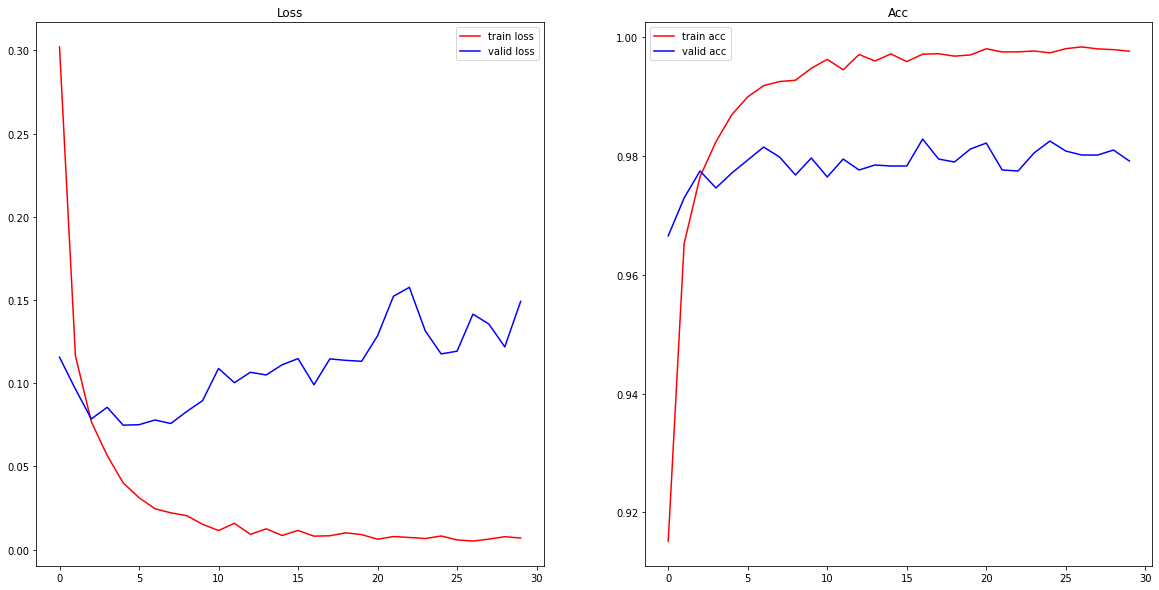

In [54]:
# mnist, scheduler X, adam
trainer = Trainer(model_class=myMNISTClassifier, loaders=loaders["mnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

Adjusting learning rate of group 0 to 1.0000e-03.
===== Train Start =====
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 0, train loss: 0.311906, train acc: 0.909568, valid loss: 0.131454, valid acc: 0.960685
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Epoch: 5, train loss: 0.018921, train acc: 0.994402, valid loss: 0.068128, valid acc: 0.982863
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Epoch: 10, train loss: 0.002855, train acc: 0.999574, valid loss: 0.078408, valid acc: 0.982359
Adjusting learning rate of group 0 to 2.5000e-04.
Adjusting learning rate of group 0 to 2.

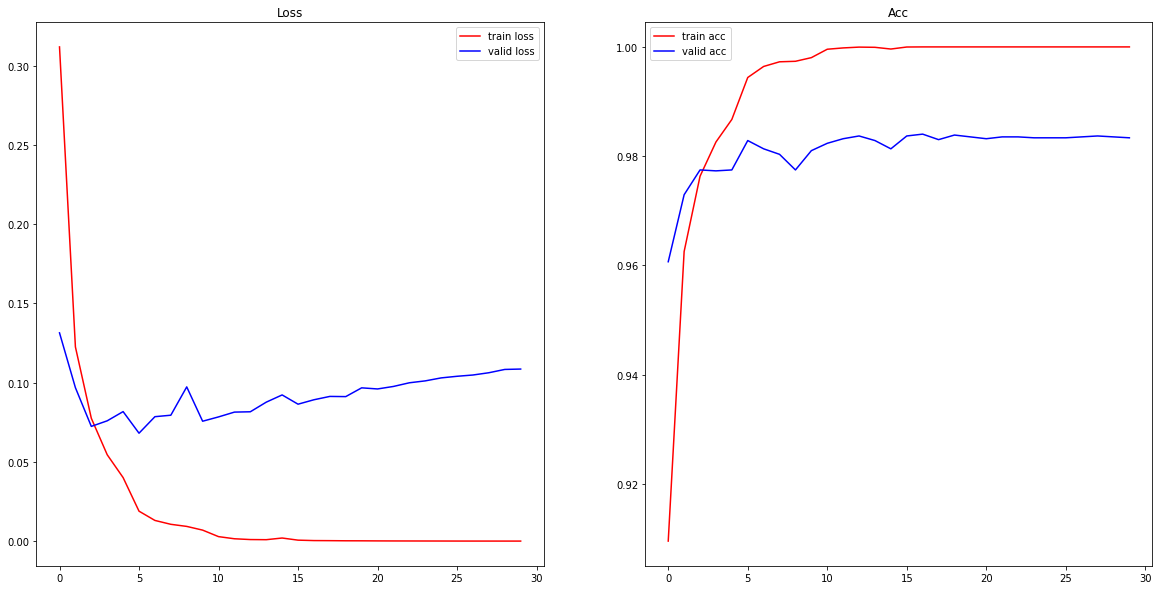

In [55]:
# mnist, scheduler O, adam
trainer = Trainer(model_class=myMNISTClassifier, loaders=loaders["mnist"], n_class=10, opt="adam", lr=0.001, has_scheduler=True, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

===== Train Start =====
Epoch: 0, train loss: 0.543020, train acc: 0.807255, valid loss: 0.394667, valid acc: 0.859879
Epoch: 5, train loss: 0.276386, train acc: 0.896111, valid loss: 0.336080, valid acc: 0.879200
Epoch: 10, train loss: 0.218573, train acc: 0.917834, valid loss: 0.322136, valid acc: 0.888609
Epoch: 15, train loss: 0.180493, train acc: 0.930234, valid loss: 0.330186, valid acc: 0.899362
Epoch: 20, train loss: 0.152280, train acc: 0.941448, valid loss: 0.379189, valid acc: 0.889113
Epoch: 25, train loss: 0.127513, train acc: 0.951624, valid loss: 0.403945, valid acc: 0.898017
===== Test Start =====
Test loss: 0.461470, Test acc: 0.884315


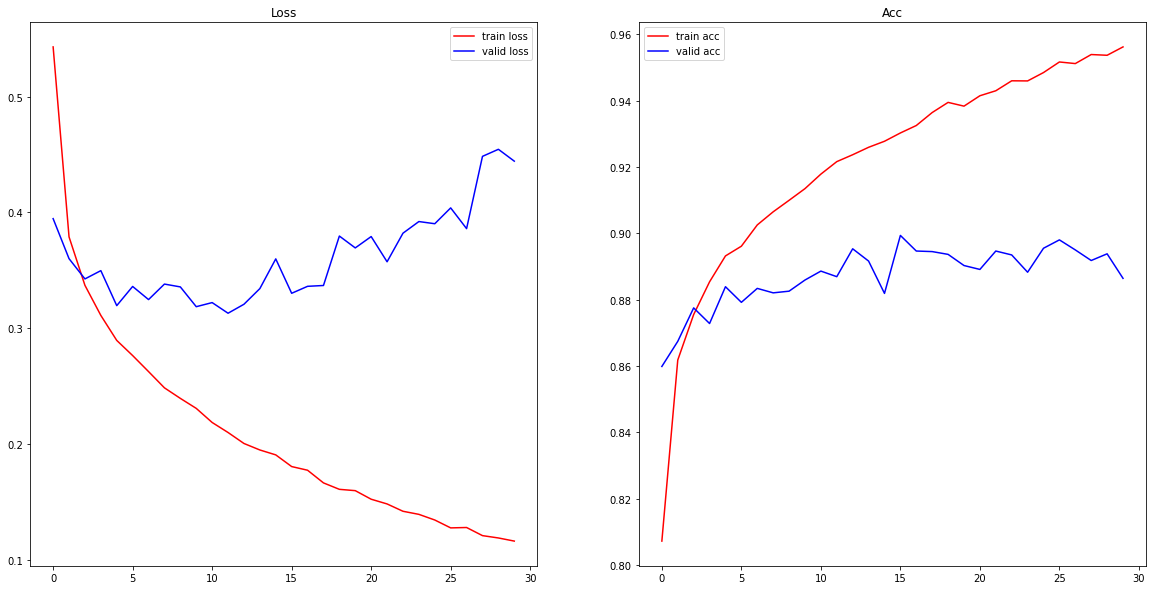

In [56]:
# fmnist, scheduler X, adam 
trainer = Trainer(model_class=myMNISTClassifier, loaders=loaders["fmnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

===== Train Start =====
Epoch: 0, train loss: 0.447638, train acc: 0.864620, valid loss: 0.270532, valid acc: 0.917003
Epoch: 5, train loss: 0.042409, train acc: 0.986377, valid loss: 0.166416, valid acc: 0.956149
Epoch: 10, train loss: 0.020734, train acc: 0.993105, valid loss: 0.195440, valid acc: 0.959509
Epoch: 15, train loss: 0.010520, train acc: 0.996515, valid loss: 0.244667, valid acc: 0.958501
Epoch: 20, train loss: 0.010045, train acc: 0.996608, valid loss: 0.258952, valid acc: 0.961190
Epoch: 25, train loss: 0.010640, train acc: 0.996775, valid loss: 0.280275, valid acc: 0.961862
===== Test Start =====
Test loss: 0.807482, Test acc: 0.906751


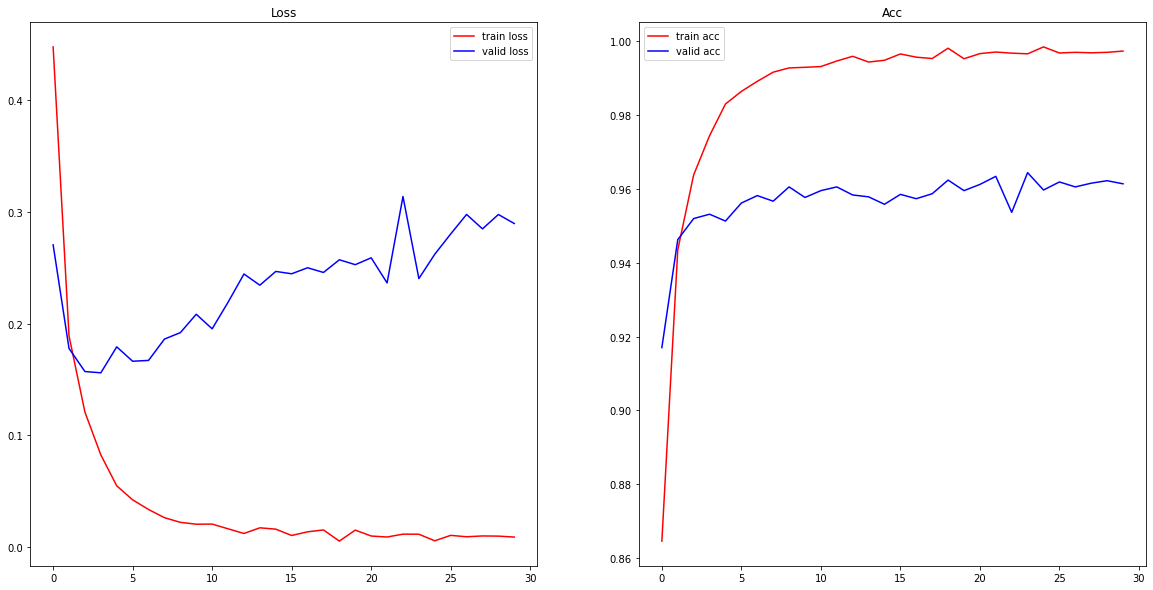

In [57]:
# kmnist, scheduler X, adam
trainer = Trainer(model_class=myMNISTClassifier, loaders=loaders["kmnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

===== Train Start =====
Epoch: 0, train loss: 0.878400, train acc: 0.742960, valid loss: 0.591032, valid acc: 0.806310
===== Test Start =====
Test loss: 0.441327, Test acc: 0.845393


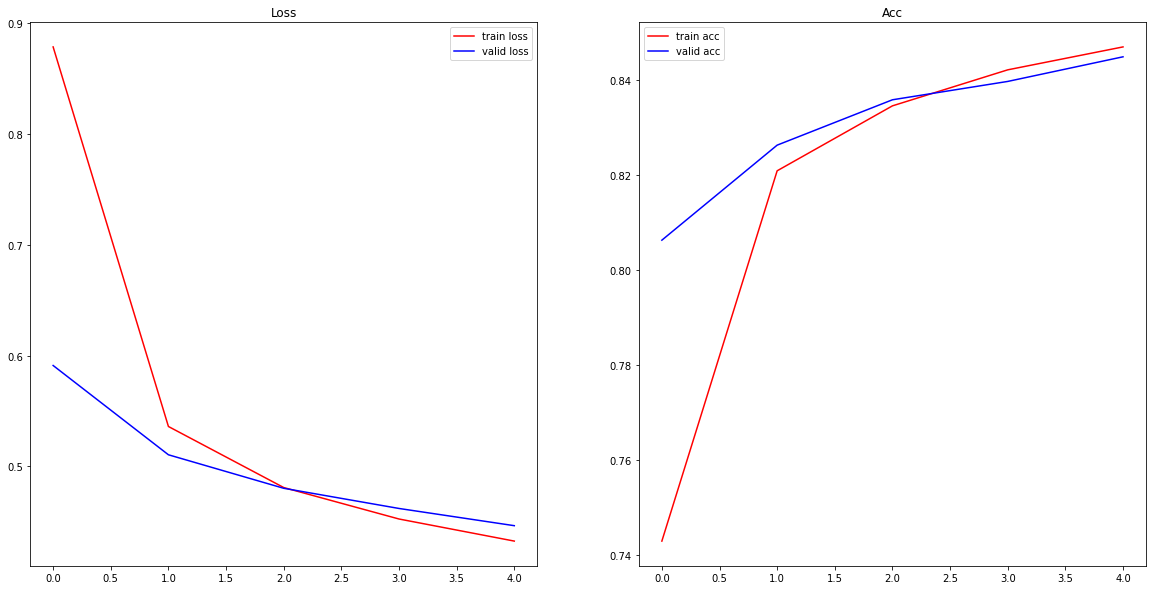

In [58]:
# emnist, scheduler X, adam
trainer = Trainer(model_class=myMNISTClassifier, loaders=loaders["emnist"], n_class=62, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=5)
trainer.test()

In [ ]:
# 동시에 돌리는 법 (반복문)

table = {"mnist": 10, "fmnist": 10, "kmnist": 10, "emnist": 62}
for d_name in ["mnist", "fmnist", "kmnist", "emnist"]:
  print(f"Start short training dataset {d_name} with adam optimizer")
  trainer = Trainer(model_class=myMNISTClassifier, loaders=loaders[d_name], n_class=table[d_name], opt="adam", lr=0.001, device=device).to(device)
  trainer.train(max_epochs = 15 if d_name != "emnist" else 5)
  trainer.test()

# 5.4. Model with dropout and batch normalization

In [59]:
# Dropout 사용
class myMNISTDropoutClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)


# Batchnorm 사용
class myMNISTBNClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)


# Batchnorm, Dropout 사용
class myMNISTDropoutBNClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

===== Train Start =====
Epoch: 0, train loss: 0.700831, train acc: 0.745811, valid loss: 0.444637, valid acc: 0.835685
Epoch: 5, train loss: 0.405065, train acc: 0.855483, valid loss: 0.346631, valid acc: 0.876344
Epoch: 10, train loss: 0.367158, train acc: 0.866122, valid loss: 0.340977, valid acc: 0.879872
Epoch: 15, train loss: 0.344452, train acc: 0.874277, valid loss: 0.319099, valid acc: 0.877688
Epoch: 20, train loss: 0.330073, train acc: 0.879096, valid loss: 0.312785, valid acc: 0.883905
Epoch: 25, train loss: 0.318614, train acc: 0.883508, valid loss: 0.318341, valid acc: 0.882056
===== Test Start =====
Test loss: 0.338136, Test acc: 0.880308


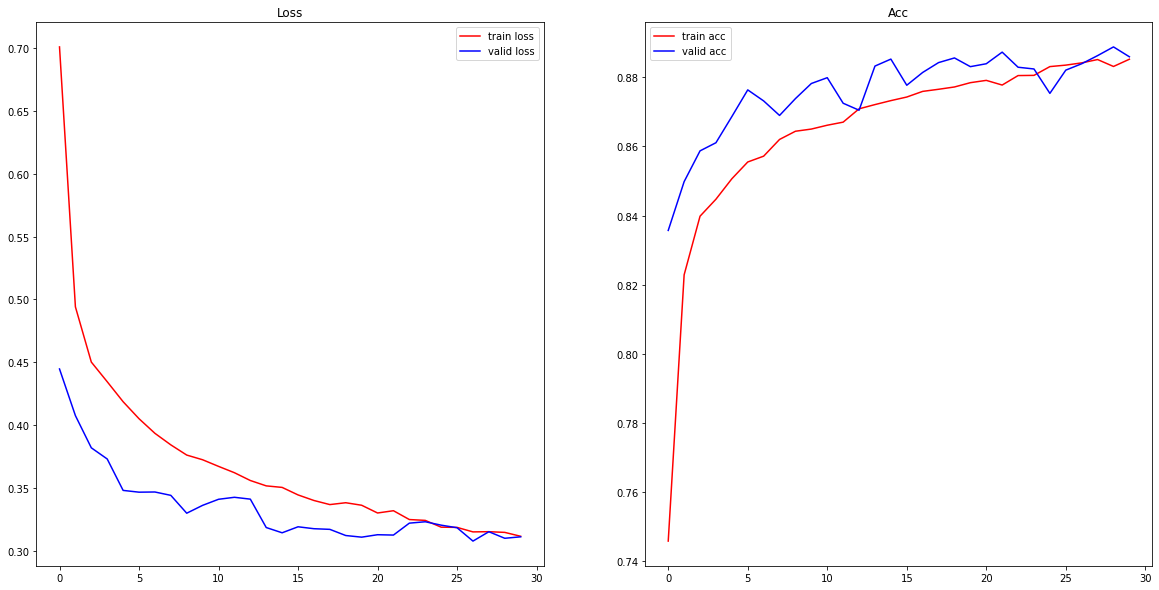

In [60]:
trainer = Trainer(model_class=myMNISTDropoutClassifier, loaders=loaders["fmnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

===== Train Start =====
Epoch: 0, train loss: 0.460602, train acc: 0.838134, valid loss: 0.378122, valid acc: 0.858871
Epoch: 5, train loss: 0.238365, train acc: 0.911329, valid loss: 0.323173, valid acc: 0.883401
Epoch: 10, train loss: 0.173836, train acc: 0.934849, valid loss: 0.316617, valid acc: 0.890961
Epoch: 15, train loss: 0.127051, train acc: 0.951272, valid loss: 0.338476, valid acc: 0.894321
Epoch: 20, train loss: 0.105009, train acc: 0.960613, valid loss: 0.392780, valid acc: 0.892137
Epoch: 25, train loss: 0.083526, train acc: 0.968101, valid loss: 0.400622, valid acc: 0.893649
===== Test Start =====
Test loss: 0.502947, Test acc: 0.884415


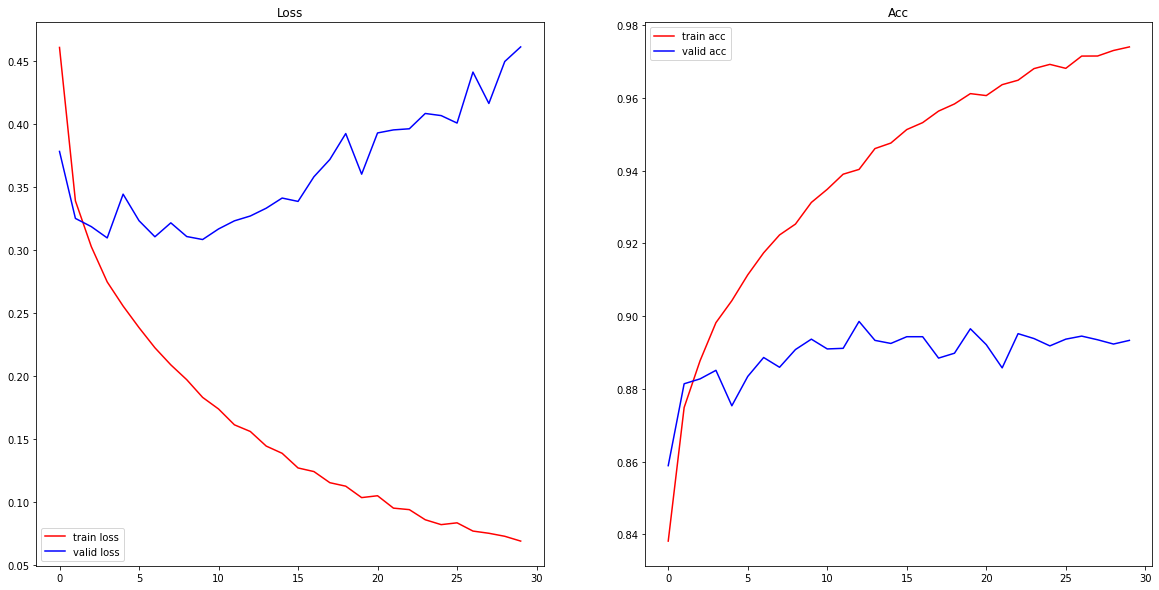

In [61]:
trainer = Trainer(model_class=myMNISTBNClassifier, loaders=loaders["fmnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

===== Train Start =====
Epoch: 0, train loss: 0.621669, train acc: 0.788238, valid loss: 0.419521, valid acc: 0.840054
Epoch: 5, train loss: 0.387329, train acc: 0.860394, valid loss: 0.334621, valid acc: 0.873656
Epoch: 10, train loss: 0.341954, train acc: 0.875445, valid loss: 0.311503, valid acc: 0.886425
Epoch: 15, train loss: 0.313068, train acc: 0.885491, valid loss: 0.299177, valid acc: 0.889785
Epoch: 20, train loss: 0.297950, train acc: 0.891014, valid loss: 0.283933, valid acc: 0.896169
Epoch: 25, train loss: 0.281906, train acc: 0.895982, valid loss: 0.284885, valid acc: 0.895161
===== Test Start =====
Test loss: 0.313611, Test acc: 0.890625


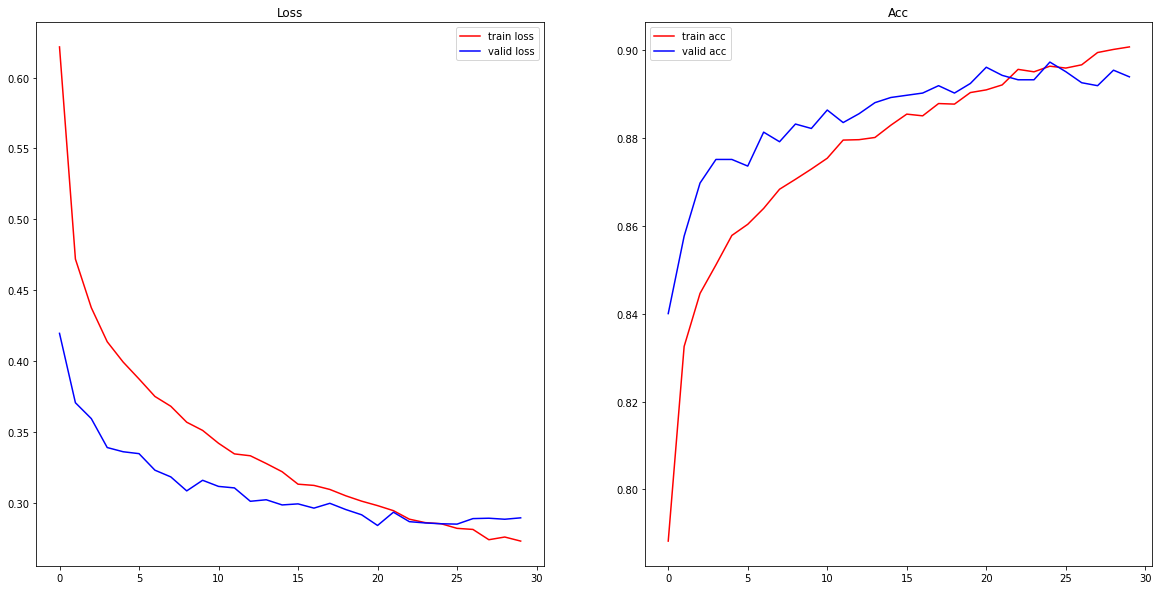

In [62]:
trainer = Trainer(model_class=myMNISTDropoutBNClassifier, loaders=loaders["fmnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()